In [ ]:
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
"""

In [2]:
#imports 

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf


**Step One. Importing and reading data, problem description**

First, we are going to look at the provided dataset.

We have in our hands a set of 220.025 histological images with typical H-E tinction labeled as cancer or not cancer. No info about types of cancer, and no demographic data about patients. 

In that way of reasoning, we have a binary classification problem with a lot of data, and pretty complex data as those histological images are similar between each other, not homogeneous and probably coming from different hospitals, care centers, patients, and even organs.

The dataset images are on tiff format and size is 96px X 96px X 3chanels (RGB).


In [5]:
#Read
df_train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv') 

print (df_train.head())
print (df_train.shape)

#As we are going to need URL to images we are going to create new colummn with this path
#path to actual images in new colummn
df_train['location'] = '/kaggle/input/histopathologic-cancer-detection/train/' + df_train['id'] + '.tif'

#Most networks will need label as string so lets convert it
df_train["label"] = df_train["label"].astype(str)  # Convert to string

#We are first going to test various networks so lest get a random sample, this is for reducing the time of trining
df_sampled = df_train.sample(n=1024, random_state=42)  # Set seed for reproducibility


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
(220025, 2)


**Step Two. Basic EDA.**

We are just looking at some images and its label, so not much here to explore.

Lest take a look at distribution of labels, check for duplicates or null values, and some examples of pictures with diferent labels.



In [ ]:
#NN

print ('Overview of dataset')
print(df_train.info())  
print()
duplicates = df_train.duplicated(subset=['id']).sum()
print(f'Duplicates\n{duplicates}')
print()
print('Check missing values')
print(df_train.isnull().sum())
print()
print('Labels')
df_train['label'].value_counts()

# Count values
total = len(df_train)  # Total number of rows
plt.figure(figsize=(6,6))

ax = sns.countplot(data=df_train, x='label', palette='viridis')

# Add percentages on bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'  # Calculate %
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('Class Distribution with Percentages')
plt.show()

#preview of first 10 images ant its labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    img = mpimg.imread(df_train['location'].iloc[i])  # Load image
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(f"Label: {df_train.loc[i, 'label']}")  # Show label

plt.tight_layout()
plt.show()



**Step Three. DModel Architecture**

As we expected images are very complex, labels are not distributed perfectly so we have more benign than malignant samples, but this is not a problem because in the medical centers there is going to be usually a distribution where benign pathology is far more common than cancer.

This complex data is going to be examined using CNN. So, we are going to take sampled data and train some networks with default parameters.

After researching a little bit, it seems for this type of histological images DenseNet-169, ResNet-50 and EfficientNetB0 are the top three recommended.
Lest try them (with small data) and the one with better performance will be fine-tuned.


In [3]:
#imports for CNNs

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, Hinge
from tensorflow.keras.metrics import AUC


In [ ]:
# Cheking similar distribution between sample and complete df.

total = len(df_sampled)  # Total number of rows
plt.figure(figsize=(6,6))

ax = sns.countplot(data=df_sampled, x='label', palette='viridis')

# Add percentages on bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'  # Calculate %
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('Class Distribution with Percentages')
plt.show()


In [ ]:
# Load EfficientNetB0  (Feature Extractor)
EfficientNet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  
EfficientNet_model.trainable = True  # Allow fine-tuning

# Add Custom Classifier for Binary Classification
x = GlobalAveragePooling2D()(EfficientNet_model.output)  # Convert feature maps to vector
x = Dense(128, activation="relu")(x)  # Dense Layer
x = Dense(1, activation="sigmoid")(x)  # Binary Classification (Sigmoid Output)

# Create Model
model_Eff = Model(inputs=EfficientNet_model.input, outputs=x)

# Compile Model (Use Binary Loss & AUC Metric)
model_Eff.compile(optimizer=Adam(learning_rate=1e-5), 
              loss="binary_crossentropy", 
              metrics=["binary_accuracy", AUC(name="auc")])

datagen_Eff = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 80-20 train-val split
)
train_generator_Eff = datagen_Eff.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(224, 224), batch_size=64, subset="training",
    class_mode="binary"  # Important for Binary Classification
)

val_generator_Eff = datagen_Eff.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(224, 224), batch_size=64, subset="validation",
    class_mode="binary"
)

# Train the Model
model_Eff.fit(train_generator_Eff, validation_data=val_generator_Eff, epochs=10)

# Evaluate on Validation Set
val_loss, val_acc, val_auc = model_Eff.evaluate(val_generator_Eff)
print(f"✅ EfficientNetB0 Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")



In [ ]:
#ResNet50 
Res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
Res_model.trainable = True  # Allow fine-tuning

# Add Custom Classifier for Binary Classification
x = GlobalAveragePooling2D()(Res_model.output)  # Convert feature maps to vector
x = Dense(128, activation="relu")(x)  # Dense Layer
x = Dense(1, activation="sigmoid")(x)  # Binary Classification (Sigmoid Output)

# Create Model
model_Res = Model(inputs=Res_model.input, outputs=x)

# Compile Model (Use Binary Loss & AUC Metric)
model_Res.compile(optimizer=Adam(learning_rate=1e-5), 
              loss="binary_crossentropy", 
              metrics=["binary_accuracy", AUC(name="auc")])

datagen_Res = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 80-20 train-val split
)
train_generator_Res = datagen_Res.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="training",
    class_mode="binary"
)

val_generator_Res = datagen_Res.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="validation",
    class_mode="binary"
)

# Train the Model
model_Res.fit(train_generator_Res, validation_data=val_generator_Res, epochs=10)

# Evaluate on Validation Set
val_loss, val_acc, val_auc = model_Res.evaluate(val_generator_Res)
print(f"✅ ResNet50 Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")# Load ResNet50 WITHOUT Top Layers (Feature Extractor)

In [ ]:
#Load DenseNet-169 WITHOUT Top Layers (Feature Extractor)
DenseN_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
DenseN_model.trainable = True  # Allow fine-tuning

# Add Custom Classifier for Binary Classification
x = GlobalAveragePooling2D()(DenseN_model.output)  # Convert feature maps to vector
x = Dense(128, activation="relu")(x)  # Dense Layer
x = Dense(1, activation="sigmoid")(x)  # Binary Classification (Sigmoid Output)

# Create Model
model_DenseN = Model(inputs=DenseN_model.input, outputs=x)

# Compile Model (Use Binary Loss & AUC Metric)
model_DenseN.compile(optimizer=Adam(learning_rate=1e-5), 
              loss="binary_crossentropy", 
              metrics=["binary_accuracy", AUC(name="auc")])

datagen_DenseN = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 80-20 train-val split
)
train_generator_DenseN = datagen_DenseN.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="training",
    class_mode="binary"
)

val_generator_DenseN = datagen_DenseN.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="validation",
    class_mode="binary"
)

# Train the Model
model_DenseN.fit(train_generator_DenseN, validation_data=val_generator_DenseN, epochs=10)

# Evaluate on Validation Set
val_loss, val_acc, val_auc = model_DenseN.evaluate(val_generator_DenseN)
print(f"✅ DenseNet-169 Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

**Step Four Results and Analysis**

So taking a look epoch by epoch in three trained CNN.

In [ ]:
import time

# Train EfficientNetB0
start_time = time.time()
history_efficient = model_Eff.fit(train_generator_Eff, validation_data=val_generator_Eff, epochs=10)
efficient_time = time.time() - start_time

# Train ResNet50
start_time = time.time()
history_resnet = model_Res.fit(train_generator_Res, validation_data=val_generator_Res, epochs=10)
resnet_time = time.time() - start_time

# Train DenseNet-169
start_time = time.time()
history_densenet = model_DenseN.fit(train_generator_DenseN, validation_data=val_generator_DenseN, epochs=10)
densenet_time = time.time() - start_time

# Extract Performance Metrics
epochs = range(1, 11)

efficient_acc = history_efficient.history["val_binary_accuracy"]
efficient_auc = history_efficient.history["val_auc"]

resnet_acc = history_resnet.history["val_binary_accuracy"]
resnet_auc = history_resnet.history["val_auc"]

densenet_acc = history_densenet.history["val_binary_accuracy"]
densenet_auc = history_densenet.history["val_auc"]

# 📌 Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, efficient_acc, label="EfficientNetB0", marker="o")
plt.plot(epochs, resnet_acc, label="ResNet50", marker="o")
plt.plot(epochs, densenet_acc, label="DenseNet-169", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison: Validation Accuracy")
plt.legend()

# 📌 Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, efficient_auc, label="EfficientNetB0", marker="o")
plt.plot(epochs, resnet_auc, label="ResNet50", marker="o")
plt.plot(epochs, densenet_auc, label="DenseNet-169", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.title("Model Comparison: AUC Score")
plt.legend()

plt.show()

# 📌 Compare Training Speed
print(f"⏳ Training Time (Seconds):")
print(f"✅ EfficientNetB0: {efficient_time:.2f} sec")
print(f"✅ ResNet50: {resnet_time:.2f} sec")
print(f"✅ DenseNet-169: {densenet_time:.2f} sec")


**Fine Tuning**

Here we have a the same winner by time and by performace DenseNet-169. So lest play with some parameters an see if we can improve even more.


In [ ]:
import keras_tuner as kt

def build_model(hp):
    base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = True  # Allow fine-tuning
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification
    
    model = Model(inputs=base_model.input, outputs=x)
    
    # 📌 Hyperparameters for tuning
    learning_rate = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])
    optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    loss = hp.Choice("loss", ["binary_crossentropy", "hinge"])
    
    # Select optimizer
    if optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == "rmsprop":
        opt = RMSprop(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=opt, loss=loss, metrics=["binary_accuracy", tf.keras.metrics.AUC(name="auc")])
    
    return model

tuner = kt.GridSearch(
    hypermodel=build_model,
    objective="val_binary_accuracy",
    max_trials=10,  # Number of different combinations to try
    executions_per_trial=1  # Run each configuration once
)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="training",
    class_mode="binary"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_sampled, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="validation",
    class_mode="binary"
)

# Perform hyperparameter search
tuner.search(train_generator, validation_data=val_generator, epochs=5)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")
print(f"Best Loss Function: {best_hps.get('loss')}")


**Step 5. Conclusion**

So after fine tuning we got some info of the best parameters and we will use all images.

Be patient.

Also it seems 10 epochs is to much, so i will use 5 instead.

Best val_binary_accuracy So Far: 0.8235294222831726

Best Learning Rate: 0.0001

Best Optimizer: adam

Best Loss Function: hinge


In [6]:
#Data for final model

datagen_final = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 80-20 train-val split
)
train_generator_final = datagen_final.flow_from_dataframe(
    dataframe=df_train, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="training",
    class_mode="binary"
)

val_generator_final = datagen_final.flow_from_dataframe(
    dataframe=df_train, directory=None, x_col="location", y_col="label",
    target_size=(96, 96), batch_size=64, subset="validation",
    class_mode="binary"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [7]:
#Final model with best features
final_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
final_model.trainable = True  # Allow fine-tuning

# Add Custom Classifier for Binary Classification
x = GlobalAveragePooling2D()(final_model.output)  # Convert feature maps to vector
x = Dense(128, activation="relu")(x)  # Dense Layer
x = Dense(1, activation="sigmoid")(x)  # Binary Classification (Sigmoid Output)

# Create Model
model_final = Model(inputs=final_model.input, outputs=x)

# Compile Model (Use Binary Loss & AUC Metric)
model_final.compile(optimizer=Adam(learning_rate=0.0001), 
              loss="hinge", 
              metrics=["binary_accuracy", AUC(name="auc")])


In [8]:
final_history = model_final.fit(train_generator_final, validation_data=val_generator_final, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 879s 234ms/step - auc: 0.9207 - binary_accuracy: 0.8935 - loss: 0.7069 - val_auc: 0.9334 - val_binary_accuracy: 0.9208 - val_loss: 0.6754
Epoch 2/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 520s 189ms/step - auc: 0.9301 - binary_accuracy: 0.9237 - loss: 0.6706 - val_auc: 0.8918 - val_binary_accuracy: 0.8943 - val_loss: 0.7018
Epoch 3/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 521s 189ms/step - auc: 0.9327 - binary_accuracy: 0.9280 - loss: 0.6663 - val_auc: 0.9348 - val_binary_accuracy: 0.9222 - val_loss: 0.6740
Epoch 4/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 521s 189ms/step - auc: 0.9405 - binary_accuracy: 0.9361 - loss: 0.6609 - val_auc: 0.9412 - val_binary_accuracy: 0.9409 - val_loss: 0.6551
Epoch 5/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 516s 187ms/step - auc: 0.9421 - binary_accuracy: 0.9398 - loss: 0.6556 - val_auc: 0.9343 - val_binary_accuracy: 0.9356 - val_loss: 0.6605


In [12]:
val_loss, val_acc, val_auc = model_final.evaluate(val_generator_final)
print(f"✅ FINAL MODEL on Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")


688/688 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - auc: 0.9331 - binary_accuracy: 0.9351 - loss: 0.6586
✅ FINAL MODEL on Validation Accuracy: 0.9356, AUC: 0.9343


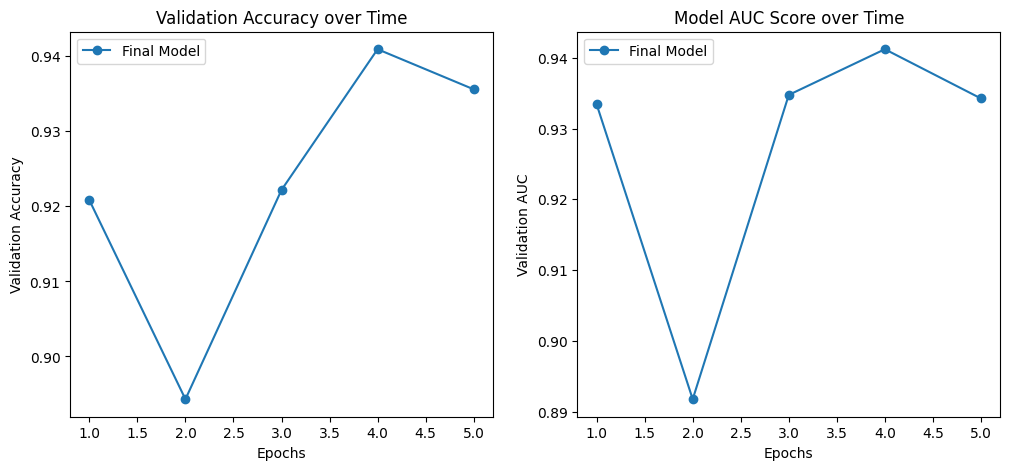

In [11]:
# Extract history from your existing object
epochs = range(1, 6)

final_acc = final_history.history["val_binary_accuracy"]
final_auc = final_history.history["val_auc"]

# 📌 Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, final_acc, label="Final Model", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Time")
plt.legend()

# 📌 Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, final_auc, label="Final Model", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.title("Model AUC Score over Time")
plt.legend()

plt.show()


**Final Thoughts**

I have to say this performance is better than i expected. Pathologist take years of training for this task so i am amazed.
In conclusión testing some networks and tuning its parameters with taking lots of info as an imput inproved perfomance to reach a 0.95 accuracy. I guess if you keep fine tuning you could probable keep improving.

In [14]:
# working on test for submition
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"

# Create DataFrame with columns 'id' and 'path'
df_test = pd.DataFrame({
    'id': [f for f in os.listdir(test_dir)],
    'path': [os.path.join(test_dir, f) for f in os.listdir(test_dir)],
    'predicted label': None  # Placeholder for predictions
})

print(df_test.head())

                                             id  \
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif   
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif   
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif   
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif   
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif   

                                                path predicted label  
0  /kaggle/input/histopathologic-cancer-detection...            None  
1  /kaggle/input/histopathologic-cancer-detection...            None  
2  /kaggle/input/histopathologic-cancer-detection...            None  
3  /kaggle/input/histopathologic-cancer-detection...            None  
4  /kaggle/input/histopathologic-cancer-detection...            None  


In [15]:
# Define ImageDataGenerator
datagen_test = ImageDataGenerator(rescale=1./255)

# Create a test generator
test_generator = datagen_test.flow_from_dataframe(
    dataframe=df_test,
    x_col="path",   # The column with image file paths
    target_size=(96, 96),  # Match model input size
    batch_size=64,  # Adjust batch size based on GPU memory
    class_mode=None,  # No labels for test data
    shuffle=False  # Keep order for consistent results
)

# Predict using the generator
predictions = model_final.predict(test_generator)

# Convert sigmoid outputs to binary labels
df_test["predicted label"] = (predictions >= 0.5).astype(int)

print(df_test.head())


Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 245s 261ms/step
                                             id  \
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif   
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif   
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif   
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif   
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif   

                                                path  predicted label  
0  /kaggle/input/histopathologic-cancer-detection...                1  
1  /kaggle/input/histopathologic-cancer-detection...                0  
2  /kaggle/input/histopathologic-cancer-detection...                0  
3  /kaggle/input/histopathologic-cancer-detection...                0  
4  /kaggle/input/histopathologic-cancer-detection...                1  


In [16]:
# Save results to CSV
df_test.to_csv("submission.csv", index=False)